# Figure 3

In [1]:
import os
import sys
from scipy import stats
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

fliersize = 1

## Compute Metrics

In [5]:
def compute_metrics(g):
    return pd.Series({
        'MAE': g['abserr'].mean(),
        'R2': metrics.r2_score(g['act'], g['pred']),
        'Pearson': g['act'].corr(g['pred'], method='pearson'),
        'Spearman': g['act'].corr(g['pred'], method='spearman'),
        'AUC': (
            metrics.roc_auc_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all() and 0 < g['is_activated'].mean() < 1
            else np.nan
        ),
        'APS': (
            metrics.average_precision_score(g['is_activated'], g['pred_prob'])
            if np.isfinite(g['pred_prob']).all()
            else np.nan
        ),
    })

## Load Performance

In [6]:
def assign_repertoire(tcr):
    tcr = tcr.upper()
    if tcr == 'OTI':
        return 'OTI'
    if tcr.startswith('ED'):
        return 'Educated'
    if tcr.startswith('R'):
        return 'Human'
    return 'Naive'

In [7]:
def load_perf_data():        
    path_in = '../activation-prediction/results'
    ppdf_mice = pd.read_csv(f'{path_in}/SIINFEKL_tcr_specific_data_size.csv.gz')
    ppdf_human = pd.read_csv(f'{path_in}/VPSVWRSSL_tcr_specific_data_size.csv.gz')
    
    ppdf = pd.concat([ppdf_mice, ppdf_human])
    
    ppdf = ppdf[ppdf['normalization'].isin(['AS', 'pc'])]

    # compute metric for each validation fold separately
    mdf = pd.concat([
        # except for lmo CV where each validation fold contained a single sample
        # in that case we just compute a global average for each tcr
        ppdf.query('features=="lmo"') \
            .groupby(['features', 'tcr']) \
            .apply(compute_metrics).reset_index(),
        ppdf.query('features!="lmo"') \
            .groupby(['features', 'tcr', 'fold']) \
            .apply(compute_metrics).reset_index(),
    ])

    mdf['features'] = mdf['features'].str.upper()

    lmdf = mdf.melt(
        id_vars=['tcr', 'features', 'fold'],
        value_vars=['R2', 'Pearson', 'Spearman', 'MAE', 'APS', 'AUC'],
        var_name='Metric'
    ).rename(
        columns={'features': 'Split', 'value': 'Value'}
    )
    
    lmdf['Repertoire'] = lmdf['tcr'].apply(assign_repertoire)
    ppdf['Repertoire'] = ppdf['tcr'].apply(assign_repertoire)

    return ppdf, lmdf
ppdf, lmdf = load_perf_data()

## Colors

In [8]:
palette_tcrs = {'OTI': 'tab:green', 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }
color_random = 'silver'

## Plotting Functions

In [9]:
def plot_auc(data, ax, ylabel=None, xlabel=None, metric_func=metrics.roc_curve, metric_name='AUC'):
    if metric_func == metrics.roc_curve:
        ax.plot([0, 1], [0, 1], c=color_random, linestyle='--')
    
    groups = data.query('features == "lmo"').groupby('tcr')
    for i, (tcr, g) in enumerate(groups):
        x, y, _ = metric_func(g['is_activated'], g['pred'])
        kwargs = {
            'c': palette_tcrs[g['Repertoire'].values[0]],
            'alpha': 0.3 if tcr != 'OTI' else 1.0,
            'label': 'OTI' if tcr == 'OTI' else 'Educated' if 'ED' in tcr else 'Naive',
            'linewidth': 0.5
        }
        if metric_func == metrics.roc_curve:
            ax.plot(x, y, **kwargs)
        else:
            ax.plot(y, x, **kwargs)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_yticklabels([])
    if xlabel:
        ax.set_xlabel(xlabel)
    else:
        ax.set_xticklabels([])
        
    df_mean = lmdf[lmdf['tcr'].isin(data['tcr'])]
    df_mean = df_mean[df_mean['Split']=='LMO']
    mean = df_mean[df_mean['Metric']==metric_name]['Value'].mean()
    ax.set_title(f'Avg {metric_name}: {mean:.3f}', pad=-2, size='small')
    
    sb.despine(ax=ax)

In [10]:
def plot_metric_boxplot(metrics, ax):        
    bp_data = lmdf.query('Split == "LMO"')
    bp_data = bp_data[bp_data['Metric'].isin(metrics)]
    sb.boxplot(
        data=bp_data,
        y='Value', hue='Repertoire', ax=ax,
        x='Metric', hue_order=['OTI', 'Educated', 'Naive', 'Human'], palette=palette_tcrs,
        fliersize=fliersize,
        #color='#ffffffff'
    )
    
    ax.set_ylabel('')
    ax.legend(bbox_to_anchor=(0., 1.2), loc="upper center", ncol=4, frameon=False)
    ax.grid(False)
    sb.despine(ax=ax)

In [11]:
def plot_feature_tests(ax, metric='Spearman', do_legend=False):
    data_feats = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_feats = data_feats[data_feats['Split'].isin(['LMO', 'LPO', 'LAO'])]

    plot = sb.boxplot(data=data_feats, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax,
                     hue_order=['OTI', 'Educated', 'Naive', 'Human'], fliersize=fliersize,
                     order=['LMO', 'LPO', 'LAO'])
    
    ax.set_xlabel('Test split')
    ax.set_ylabel(metric)
    
    if not do_legend:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor=(0., 1.2), loc="upper center", ncol=4, frameon=False)
    ax.grid(False)
    sb.despine(ax=ax)

In [12]:
def plot_data_size(ax, metric='Spearman'):
    data_size = lmdf.query(f'Metric=="{metric}"').groupby([
        'Repertoire', 'Split', 'tcr'
    ])['Value'].agg('mean').reset_index()

    data_size = data_size[~data_size['Split'].isin(['LMO', 'LPO', 'LAO'])]
    data_size = data_size.replace({'Split': {
        f'L{p}O': f'{100 - p}%' for p in [10, 25, 50, 75, 90, 95]
    }})
    
    plot = sb.lineplot(data=data_size, x='Split', y='Value', hue='Repertoire', palette=palette_tcrs, ax=ax)
    
    ax.set_xlabel('Amount of training data')
    ax.set_ylabel(metric)
    
    ax.legend().remove()
    ax.grid(False)
    sb.despine(ax=ax)

In [13]:
def plot_human(ax, scale=1):
    img = plt.imread('../figures/human.png')
    color_human = mpl.colors.to_rgba(palette_tcrs['Human'])
    for i, c in enumerate(color_human):
        img[img[:,:,i]!=1, i] = c
    ax.imshow(img, extent=[1-0.4*scale, 1, 0, 0.4*scale], alpha=0.5, aspect='auto')

## Fig. 3

<ipython-input-14-36afcf74f9be>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


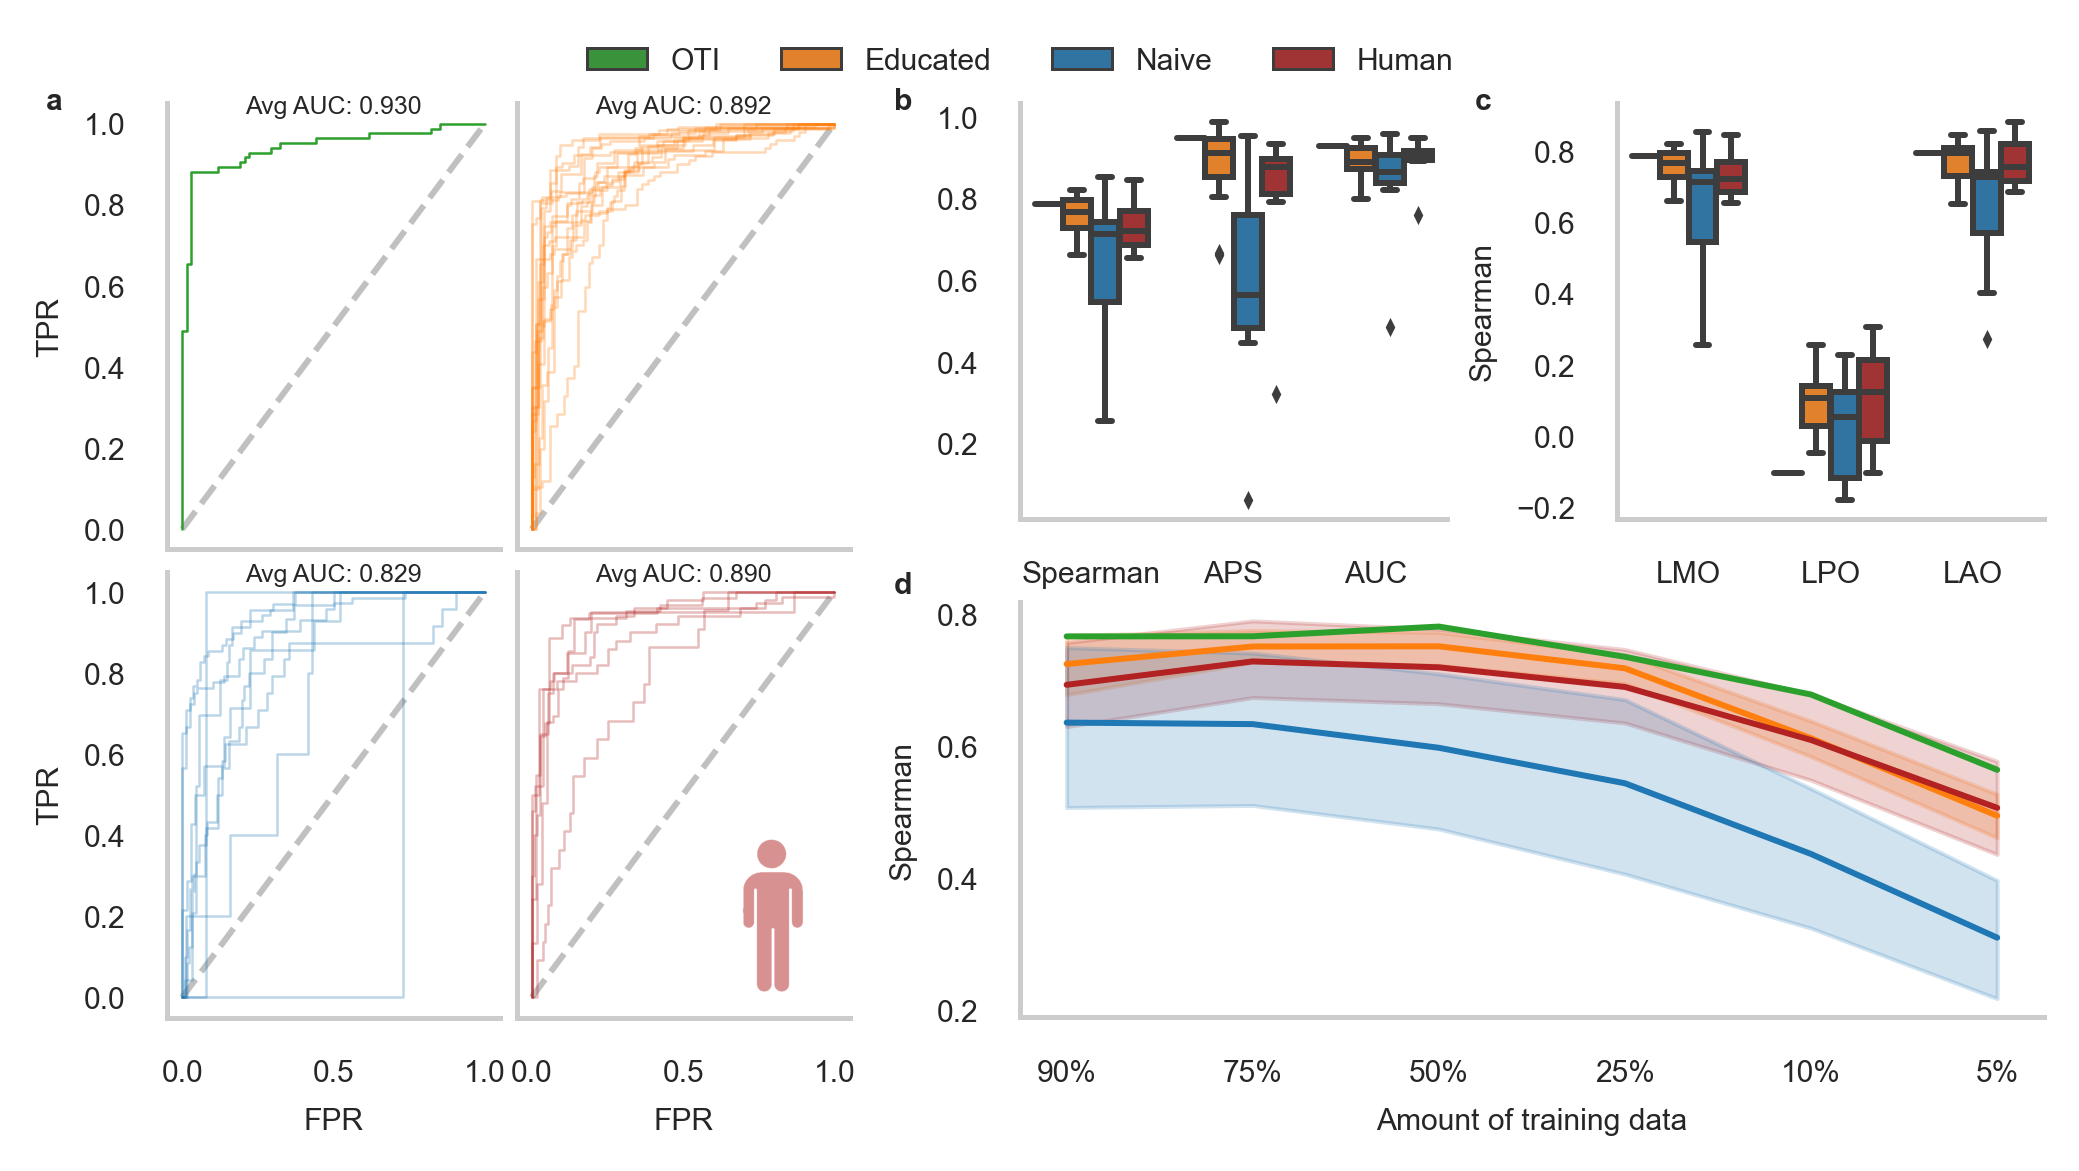

In [14]:
# a a b c 
# a a d d

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.5), dpi=DPI)

gridspecs = {}
axes = {}

gridspecs['gs_1234'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.2
)

gridspecs['gs_1'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs["gs_1234"][0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    wspace=0.05,
    hspace=0.05
)

gridspecs['gs_234'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_1234'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_234'][0],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[1, 1],
    wspace=0.4
)

for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])
axes['ax_2'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_3'] = fig.add_subplot(gridspecs['gs_23'][1])
axes['ax_4'] = fig.add_subplot(gridspecs['gs_234'][1])

plot_human(axes['ax_1_3'])

plot_auc(ppdf[ppdf['Repertoire']=='OTI'], axes['ax_1_0'], ylabel='TPR')
plot_auc(ppdf[ppdf['Repertoire']=='Educated'], axes['ax_1_1'])
plot_auc(ppdf[ppdf['Repertoire']=='Naive'], axes['ax_1_2'], ylabel='TPR', xlabel='FPR')
plot_auc(ppdf[ppdf['Repertoire']=='Human'], axes['ax_1_3'], xlabel='FPR')


plot_metric_boxplot(['Spearman', 'AUC', 'APS'], axes['ax_2'])
plot_feature_tests(axes['ax_3'])
plot_data_size(axes['ax_4'])

fig.text(0.075, 0.875, 'a', weight='bold')
fig.text(0.425, 0.875, 'b', weight='bold')
fig.text(0.665, 0.875, 'c', weight='bold')
fig.text(0.425, 0.475, 'd', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_fig3_within_tcr.pdf', dpi=DPI, bbox_inches='tight')

## Suppl. Other metrics

<ipython-input-15-fae2ca85a8b1>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


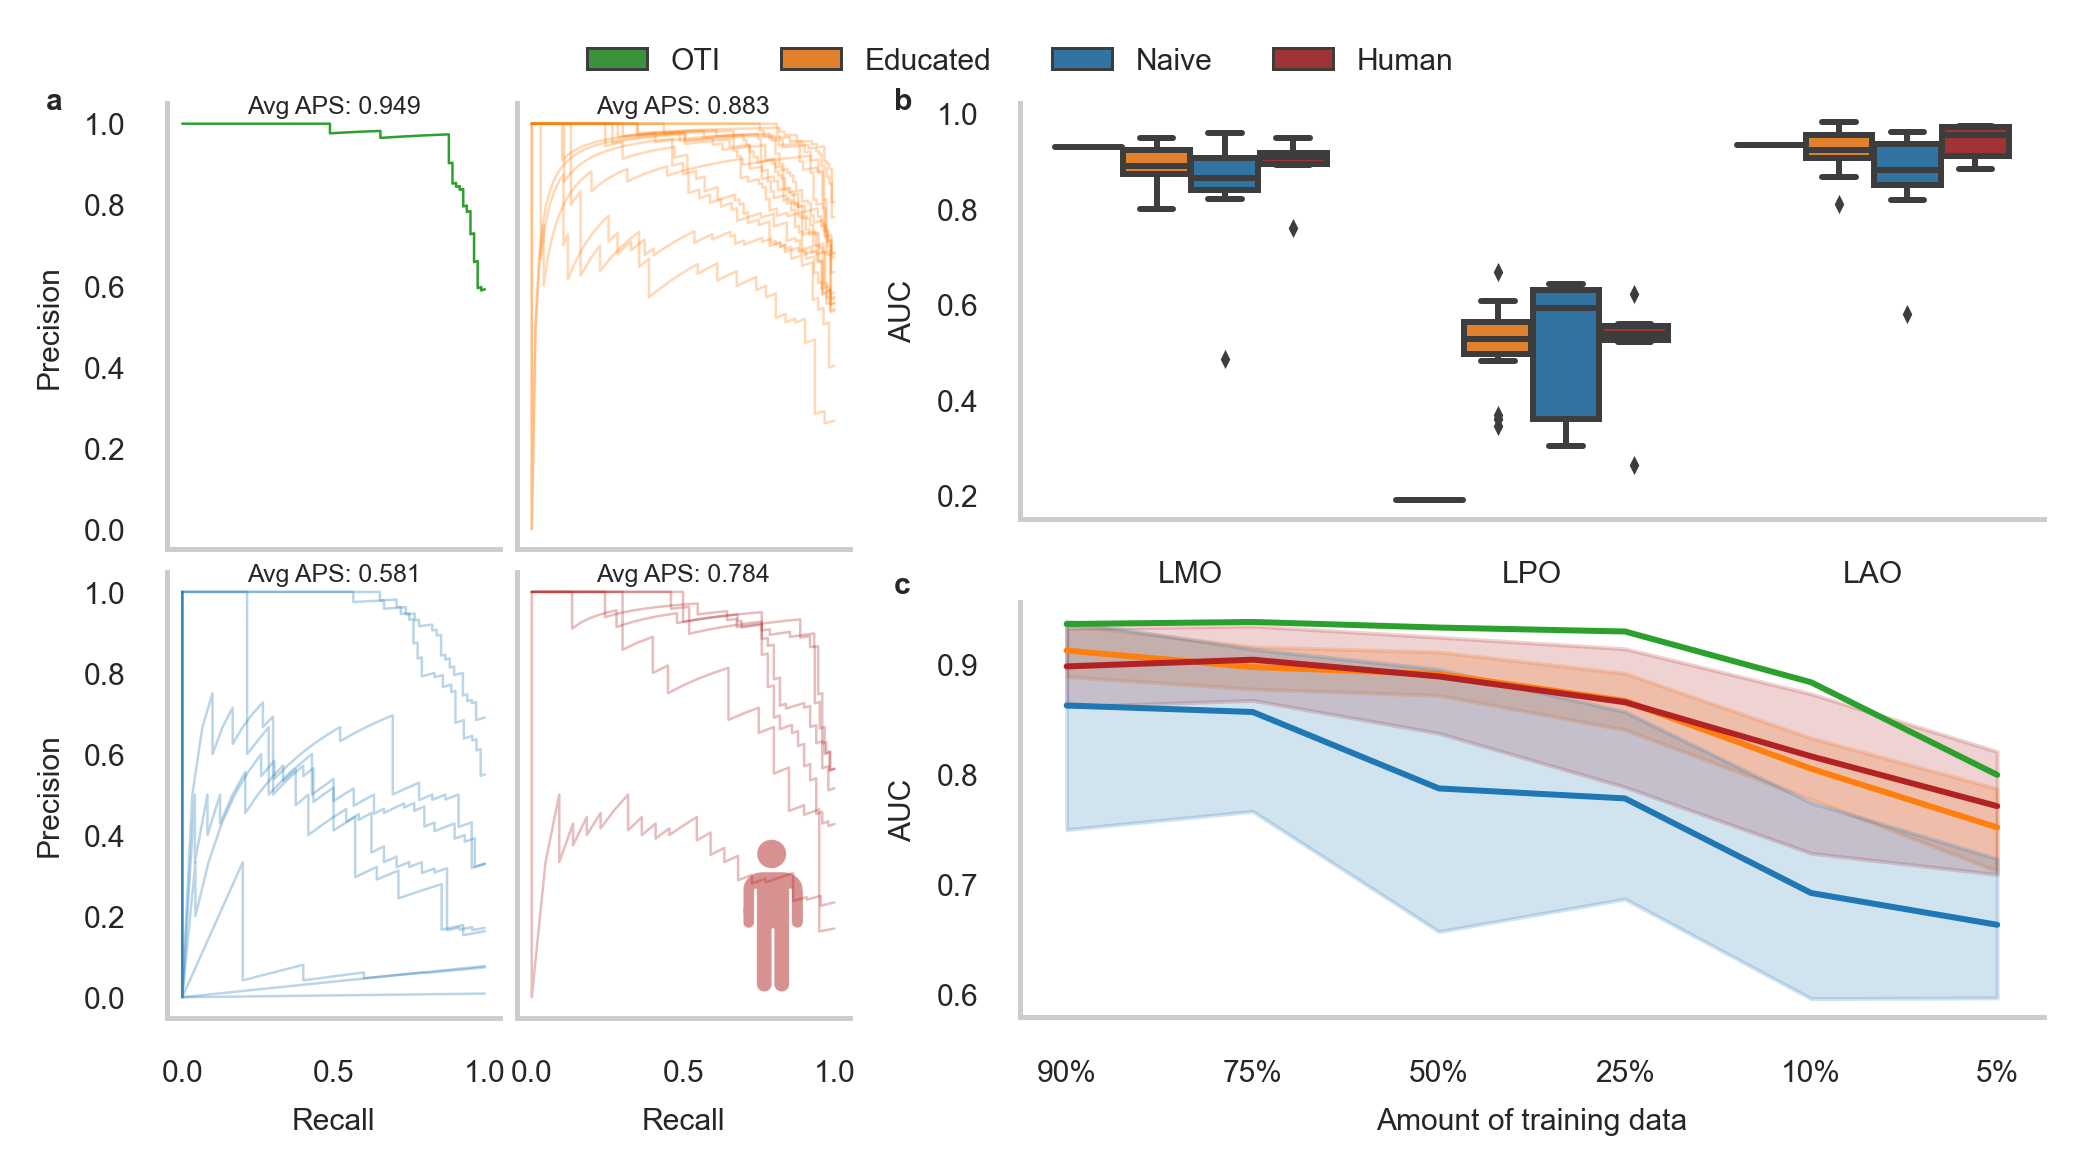

In [15]:
# a a c c 
# a a d d

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.5), dpi=DPI)

gridspecs = {}
axes = {}

gridspecs['gs_123'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    height_ratios=[1],
    width_ratios=[2, 3],
    wspace=0.2
)

gridspecs['gs_1'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 1],
    wspace=0.05,
    hspace=0.05
)

gridspecs['gs_23'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_123'][1],
    nrows=2,
    ncols=1,
    height_ratios=[1, 1],
    width_ratios=[1],
)

for i in range(4):
    axes[f'ax_1_{i}'] = fig.add_subplot(gridspecs['gs_1'][i])
axes['ax_2'] = fig.add_subplot(gridspecs['gs_23'][0])
axes['ax_3'] = fig.add_subplot(gridspecs['gs_23'][1])

plot_auc(ppdf[ppdf['Repertoire']=='OTI'], axes['ax_1_0'], ylabel='Precision',
         metric_func=metrics.precision_recall_curve, metric_name='APS')
plot_auc(ppdf[ppdf['Repertoire']=='Educated'], axes['ax_1_1'], 
         metric_func=metrics.precision_recall_curve, metric_name='APS')
plot_auc(ppdf[ppdf['Repertoire']=='Naive'], axes['ax_1_2'], ylabel='Precision', xlabel='Recall', 
         metric_func=metrics.precision_recall_curve, metric_name='APS')
plot_auc(ppdf[ppdf['Repertoire']=='Human'], axes['ax_1_3'], xlabel='Recall', 
         metric_func=metrics.precision_recall_curve, metric_name='APS')
plot_human(axes['ax_1_3'], scale=1)


plot_feature_tests(axes['ax_2'], metric='AUC', do_legend=True)
plot_data_size(axes['ax_3'], metric='AUC')

fig.text(0.075, 0.875, 'a', weight='bold')
fig.text(0.425, 0.875, 'b', weight='bold')
fig.text(0.425, 0.475, 'c', weight='bold')

fig.tight_layout()
fig.savefig('figures/manuscript_sfig3_within_tcr.pdf', dpi=DPI, bbox_inches='tight')

## Statistical Tests

In [16]:
pd.set_option('display.expand_frame_repr', False)
print('---  summary statistics\n',
      lmdf.query('Split=="LMO"') \
          .groupby(['Metric', 'Repertoire'])['Value'].describe())

---  summary statistics
                      count       mean       std        min        25%        50%        75%        max
Metric   Repertoire                                                                                   
APS      Educated     15.0   0.882845  0.101530   0.661996   0.854451   0.911739   0.945910   0.987243
         Human         6.0   0.783675  0.230869   0.322415   0.811189   0.877290   0.896481   0.933024
         Naive         7.0   0.581190  0.300983   0.062101   0.484155   0.565003   0.759270   0.954373
         OTI           1.0   0.949409       NaN   0.949409   0.949409   0.949409   0.949409   0.949409
AUC      Educated     15.0   0.892125  0.041760   0.799473   0.873060   0.890628   0.923946   0.948680
         Human         6.0   0.889605  0.066015   0.760647   0.895153   0.908312   0.917439   0.949114
         Naive         7.0   0.829115  0.157914   0.485714   0.839554   0.864907   0.907423   0.959228
         OTI           1.0   0.929884       NaN 

In [17]:
print('---  worst three educated\n',
      lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Educated"') \
          .sort_values('Value').head(3))

---  worst three educated
         tcr Split  fold Metric     Value Repertoire
11049  ED39   LMO   NaN    APS  0.661996   Educated
11046  ED28   LMO   NaN    APS  0.667884   Educated
11047  ED31   LMO   NaN    APS  0.803862   Educated


In [18]:
print('---  best two educated\n')
print(lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Educated"') \
      .sort_values('Value').tail(2))
print()
print(lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Educated"') \
          .sort_values('Value').tail(2))

---  best two educated

        tcr Split  fold Metric     Value Repertoire
11054   ED8   LMO   NaN    APS  0.980454   Educated
11044  ED21   LMO   NaN    APS  0.987243   Educated

          tcr Split  fold Metric     Value Repertoire
13801  ED16-1   LMO   NaN    AUC  0.943855   Educated
13803    ED21   LMO   NaN    AUC  0.948680   Educated


In [19]:
print('---  worst two naive\n',
      lmdf.query('Split=="LMO"&Metric=="APS"&Repertoire=="Naive"') \
          .sort_values('Value').head(2))

print('---  worst two naive\n',
      lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Naive"') \
          .sort_values('Value').head(2))
print()
print('---  best naive\n',
      lmdf.query('Split=="LMO"&Metric=="AUC"&Repertoire=="Naive"') \
          .sort_values('Value').tail(5))

---  worst two naive
       tcr Split  fold Metric     Value Repertoire
11058  G6   LMO   NaN    APS  0.062101      Naive
11040  E8   LMO   NaN    APS  0.447293      Naive
---  worst two naive
       tcr Split  fold Metric     Value Repertoire
13817  G6   LMO   NaN    AUC  0.485714      Naive
13799  E8   LMO   NaN    AUC  0.820638      Naive

---  best naive
        tcr Split  fold Metric     Value Repertoire
13797  B15   LMO   NaN    AUC  0.895399      Naive
13798   B3   LMO   NaN    AUC  0.919447      Naive
13795  B11   LMO   NaN    AUC  0.959228      Naive
13816   F5   LMO   NaN    AUC       NaN      Naive
13818   H5   LMO   NaN    AUC       NaN      Naive


In [20]:
print('---  ot1 performance\n',
      lmdf.query('Split=="LMO"&Metric=="APS"&tcr=="OTI"'))

---  ot1 performance
        tcr Split  fold Metric     Value Repertoire
11060  OTI   LMO   NaN    APS  0.949409        OTI


In [21]:
print('---  spearman by position averaging spearman of individual tcrs\n',
      ppdf.query('features=="lpo"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by position averaging spearman of individual tcrs
             rho         p
count  9.000000  9.000000
mean   0.082555  0.449725
std    0.101934  0.050738
min   -0.119311  0.363630
25%    0.036189  0.440023
50%    0.110983  0.451546
75%    0.122819  0.482432
max    0.215765  0.508710


In [22]:
print('---  spearman by amino acid averaging spearman of individual tcrs\n',
      ppdf.query('features=="lao"').groupby(['fold', 'tcr']).apply(
          lambda g: pd.Series(stats.spearmanr(g['act'], g['pred']), index=['rho', 'p'])
          ).reset_index().groupby('fold').mean().describe()
)

---  spearman by amino acid averaging spearman of individual tcrs
              rho          p
count  20.000000  20.000000
mean    0.735366   0.100003
std     0.079693   0.045757
min     0.532104   0.046832
25%     0.704454   0.062221
50%     0.753278   0.093477
75%     0.795108   0.125183
max     0.837174   0.210069


In [23]:
# t-test to find significance of split performance reduction
print('---  data size hypothesis testing')

for m in ['Spearman', 'AUC']:
    print(m)
    lmdf.query(f'Metric == "{m}"').groupby(['Split', 'tcr'])['Value'].mean().reset_index()

    for r in ['Naive', 'Educated']:
        print(f'---- {r}')
        lmo_aps = lmdf.query(f'Split=="LMO" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
        for split in lmdf['Split'].unique():
            if split == 'LMO':
                continue

            split_aps = lmdf.query(f'Split=="{split}" & Metric == "{m}" & Repertoire =="{r}"').groupby('tcr')['Value'].mean().dropna()
            assert np.all(lmo_aps.index == split_aps.index)
            tr = stats.wilcoxon(lmo_aps, split_aps, alternative='greater')
            md = split_aps.mean() - lmo_aps.mean()
            sd = np.sqrt((split_aps.var() + lmo_aps.var()) / 2)

            print(f'split {split} vs. LMO - mean difference {md:.4f} - effect size {md / sd:.4f} - W: {tr.statistic:.4f} , p: {tr.pvalue:.3e}')
    print('')    
    print('---')

---  data size hypothesis testing
Spearman
---- Naive
split L10O vs. LMO - mean difference 0.0135 - effect size 0.0656 - W: 15.0000 , p: 8.203e-01
split L25O vs. LMO - mean difference 0.0112 - effect size 0.0548 - W: 9.0000 , p: 9.512e-01
split L50O vs. LMO - mean difference -0.0247 - effect size -0.1203 - W: 39.0000 , p: 2.734e-02
split L75O vs. LMO - mean difference -0.0784 - effect size -0.3702 - W: 45.0000 , p: 1.953e-03
split L90O vs. LMO - mean difference -0.1855 - effect size -0.9638 - W: 45.0000 , p: 1.953e-03
split L95O vs. LMO - mean difference -0.3123 - effect size -1.7220 - W: 45.0000 , p: 1.953e-03
split LAO vs. LMO - mean difference 0.0171 - effect size 0.0853 - W: 9.0000 , p: 9.512e-01
split LPO vs. LMO - mean difference -0.6048 - effect size -3.3162 - W: 45.0000 , p: 1.953e-03
---- Educated
split L10O vs. LMO - mean difference -0.0347 - effect size -0.4843 - W: 92.0000 , p: 3.650e-02
split L25O vs. LMO - mean difference -0.0082 - effect size -0.1706 - W: 92.0000 , p: 3.

In [24]:
print('Spearman of LPO: \n',
    lmdf.query(f'Metric == "Spearman" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

print('\nAUC of LPO: \n',
    lmdf.query(f'Metric == "AUC" & Split == "LPO"').groupby(['Repertoire'])['Value'].mean().reset_index())

Spearman of LPO: 
   Repertoire     Value
0   Educated  0.090906
1      Human  0.106106
2      Naive  0.017876
3        OTI -0.103728

AUC of LPO: 
   Repertoire     Value
0   Educated  0.511961
1      Human  0.511233
2      Naive  0.499420
3        OTI  0.190924
